
<h1><center> <font color='black'>  Network Science (LTAT.02.011) - Practice Session - 08  </font></center></h1>
<h2><center> <font color='black'> Echo Chambers and Polarization</font></center></h3>
<h2><center> <font color='black'> University of Tartu</font></center></h3>


# Already Covered:
1. **Get familiar with the graphs and how to work with them using igraph library; [Lab - 02]**
2. **Analyse the data about media companies. Figure out their connections; [Lab - 02]**
3. **Learn about various way of displaying statistic on the graphs; [Lab - 02]**
4. **Network models and descriptions using Networkx library; [Lab - 03]**

5. **Network Centrality Measures using networkx; [Lab - 04]**
6. **Network Communities using networkx/igraph [Lab - 05]**
7. **Link Prediction [Lab - 06]**
8. **Graph Based Text Representation [Lab - 07]**

# Today's session agenda:
+ **Echo Chambers and Polarization**
  1. Homophily<br>
    1.1. Loading and understanding data<br>
    1.2. Calculating mixed edge probability<br>
    1.3. Comparing to the observed number of mixed edges<br>
    1.4. Hypothesis testing<br>
  2. Echo chamber metrics<br>
    2.1. E-I Index<br>
    2.2. Modularity score<br>
    2.3. Random Walk Controversy score<br>
  3. User type identification

## Loading and installing all required packages

In [ ]:
!pip install random-walk-controversy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch

In [ ]:
from IPython.display import Image
import pandas as pd
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

# 1. Homophily
We will learn how to identify homophily in networks. Homophily can be an indicator of echo chambers. However its always important to keep in mind, that homophily can also occur due to sampling bias, thus always check how representative is your dataset before making conclusions. In this lab we will also do a statistical test to determine the significance of homophily in our network.

In [ ]:
Image(url="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41562-019-0677-4/MediaObjects/41562_2019_677_Fig1_HTML.png", height=400)

In the example above we see that the percentage of mixed edges inside the circle is 2/7=28.5%, while in the heterophilic network it is 4/7=57.1%. Thus we expect to see a higher percentage of mixed edges in heterophilic networks.

## 1.1. Loading and understanding data
We will use the node attributes in the Quaker network from the [*Six Degrees of Francis Bacon*](http://www.sixdegreesoffrancisbacon.com/) project .


Before there were Facebook friends, there was the Society of Friends, known as the Quakers. Founded in England in the mid-seventeenth century, the Quakers were Protestant Christians who dissented from the official Church of England and promoted broad religious toleration, preferring Christians’ supposed “inner light” and consciences to state-enforced orthodoxy. Quakers’ numbers grew rapidly in the mid- to late-seventeenth century and their members spread through the British Isles, Europe, and the New World colonies—especially Pennsylvania, founded by Quaker leader William Penn and the home of your four authors.

In [ ]:
Image(url="https://hcommons.org/app/uploads/sites/1001756/2020/06/FrancisBaconNetwork-1024x786.png", height=400)

Let us first load in the edges and nodes of the dataset

In [ ]:
edges = pd.read_csv("quaker-edges.csv")
edges.head()

,Source,Target
0,George Keith,William Bradford
1,George Keith,George Whitehead
2,George Keith,George Fox
3,George Keith,William Penn
4,George Keith,Franciscus Mercurius van Helmont


In [ ]:
nodes = pd.read_csv("quaker-nodes.csv")
nodes.head()

,Id,Label,historical significance,gender,birthdate,deathdate,other_id
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848
2,Benjamin Furly,Benjamin Furly,merchant and religious writer,male,1636,1714,10004625
3,Anne Conway Viscountess Conway and Killultagh,Anne Conway Viscountess Conway and Killultagh,philosopher,female,1631,1679,10002755
4,Franciscus Mercurius van Helmont,Franciscus Mercurius van Helmont,physician and cabbalist,male,1614,1698,10005781


Let us now add the edges to a graph object

In [ ]:
quakers = nx.from_pandas_edgelist(edges, source="Source", target="Target")
print(quakers)

Graph with 96 nodes and 162 edges


And let us add the gender attributes to nodes

In [ ]:
nx.set_node_attributes(quakers, dict(zip(nodes.Id, nodes.gender)), 'gender')

## 1.2. Calculating mixed edge probability

In a network that is not homophilous, the expected probability of mixed edges is 2 times the product of the percentage of nodes in the first group ($p$) and the percentage of the nodes in the second group ($q$): $2pq$. Let us see this using gender as our group feature.

Let us first calculate the percentage of male people in the Quaker graph, using pandas

In [ ]:
p = nodes.gender.value_counts()["male"]/nodes.gender.count()
p

0.84375

Let us now calculate the percentage of female people in the Quaker graph.

In [ ]:
q = nodes.gender.value_counts()["female"]/nodes.gender.count()
q

0.15625

Now let us calculate the probability of mixed edges

In [ ]:
2*p*q

0.263671875

**What does this mean?** Well it means that if the network is not homophilous we would expect that around 26% of its edges would be mixed edges.

## 1.3. Comparing to the observed number of mixed edges

To test this we can first calculate the actual number of mixed edges and compare it to the probability above.

In [ ]:
mixed_edges = len([(s,t) for s,t in quakers.edges if quakers.nodes[s]['gender'] != quakers.nodes[t]['gender']])
mixed_edges

32

Now lets calculate the percentage of mixed edges in the network.

In [ ]:
mixed_edges/quakers.number_of_edges()

0.19753086419753085

Let’s define a “homophily” measure as the difference between the expected percentage of mixed edges and the observed percentage of mixed edges

In [ ]:
def homophily(mixed_edges):
    return 2*p*q - mixed_edges/quakers.number_of_edges()

In [ ]:
obs_homophily = homophily(mixed_edges)
obs_homophily

0.06614101080246915

Our observed homophily measure is .07: we know that the percentage of mixed edges in this graph is 7% less than the percentage we would expect to see in a graph that is not homophilous. But how do we know if this measure is significant?

## 1.4. Hypothesis testing

To see whether our graph is *significantly* homophilous, we can set up a resampling procedure to create a hypothesis test for the homophily statistic. This is similar to how you would set up a permutation test for a difference in means.

In [ ]:
def simulate_mixed_edges(data, attribute, id_attr, graph):
    attr_column = data[attribute].sample(frac=1).reset_index(drop=True) # Reshuffle column
    nx.set_node_attributes(graph, dict(zip(data[id_attr], attr_column)), attribute) # Set node attribute
    mixed_edges = len([(s,t) for s,t in graph.edges if graph.nodes[s][attribute] != graph.nodes[t][attribute]]) # Get number of mixed edges
    return mixed_edges

Lets simulate homophily 5000 times.

In [ ]:
sim_homophily = pd.Series([homophily(simulate_mixed_edges(nodes, 'gender', 'Id', quakers)) for i in range(5000)])
sim_homophily

0       0.084660
1      -0.014106
2      -0.044970
3       0.140215
4      -0.094353
          ...   
4995   -0.051143
4996    0.066141
4997   -0.057316
4998   -0.014106
4999   -0.057316
Length: 5000, dtype: float64

Lets plot this so its easier to understand.

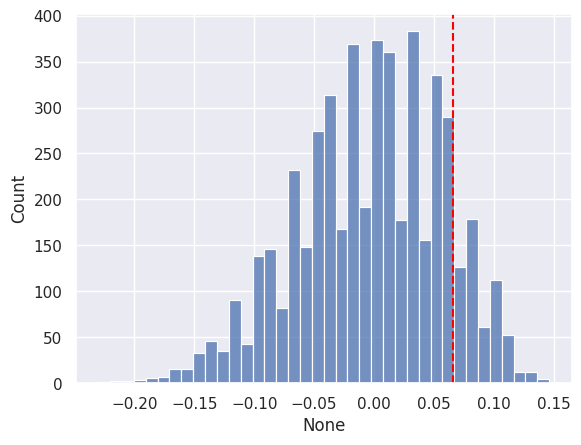

In [ ]:
plt = sns.histplot(x=sim_homophily)
plt.axvline(x=obs_homophily, color="red", ls="--")

Let us calculate a p-value.

In [ ]:
p_value = np.mean(sim_homophily > obs_homophily)
p_value

0.1118

We see that the p-value is higher than 0.05, thus we would not usually consider this statistically significant and thus we can not claim homophily in the network.

# 2. Homophily metrics

Now we will use a political blogs dataset to learn how to use different echo chamber detection metrics. Our data comes from the [polblogs dataset (2004)](https://networks.skewed.de/net/polblogs).

In [ ]:
def remove_unsupported_types(file_path, output_path):
    with open(file_path, 'r', encoding='UTF-8') as file:
        lines = file.readlines()

    unsupported_keys = []
    for line in lines:
        if 'attr.type="vector_float"' in line or 'attr.type="vector_string"' in line:
            key_id = line.split('id="')[1].split('"')[0]
            unsupported_keys.append(key_id)

    filtered_lines = []
    for line in lines:
        if any(key in line for key in unsupported_keys):
            continue
        filtered_lines.append(line)

    with open(output_path, 'w', encoding='UTF-8') as file:
        file.writelines(filtered_lines)

file_path = 'polblogs.xml'
output_path = 'polblogs_filtered.xml'
remove_unsupported_types(file_path, output_path)

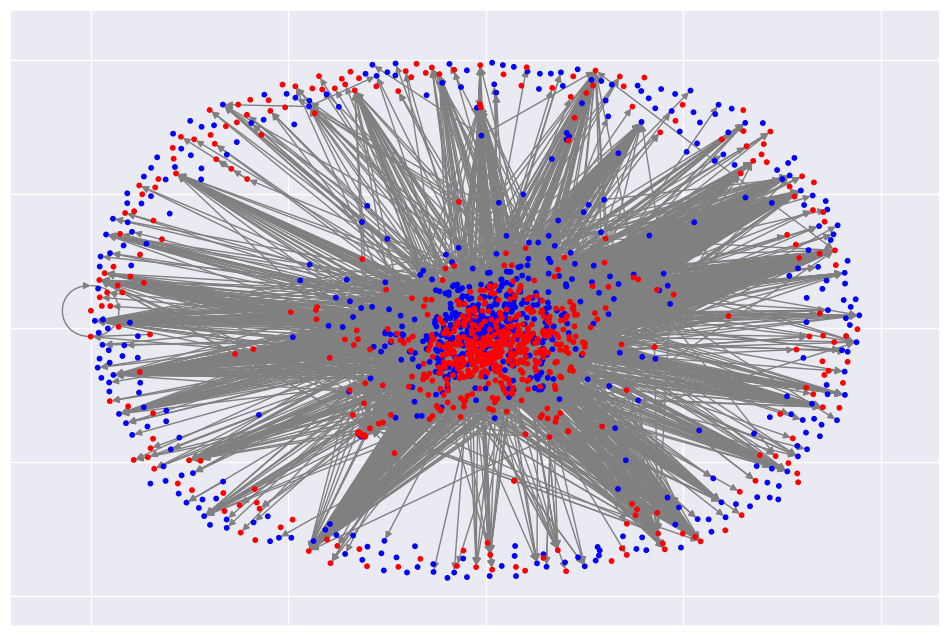

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G_polblogs = nx.read_graphml('polblogs_filtered.xml')

color_map_polblogs = {0: 'blue', 1: 'red'}
node_colors_polblogs = [color_map_polblogs[G_polblogs.nodes[node]['value']] for node in G_polblogs.nodes()]

plt.figure(figsize=(12, 8))
nx.draw_networkx(G_polblogs, node_size=10, with_labels=False, node_color=node_colors_polblogs, edge_color='gray')
plt.show()

We want to work in this case with the connected network in the middle. Let us extract that.

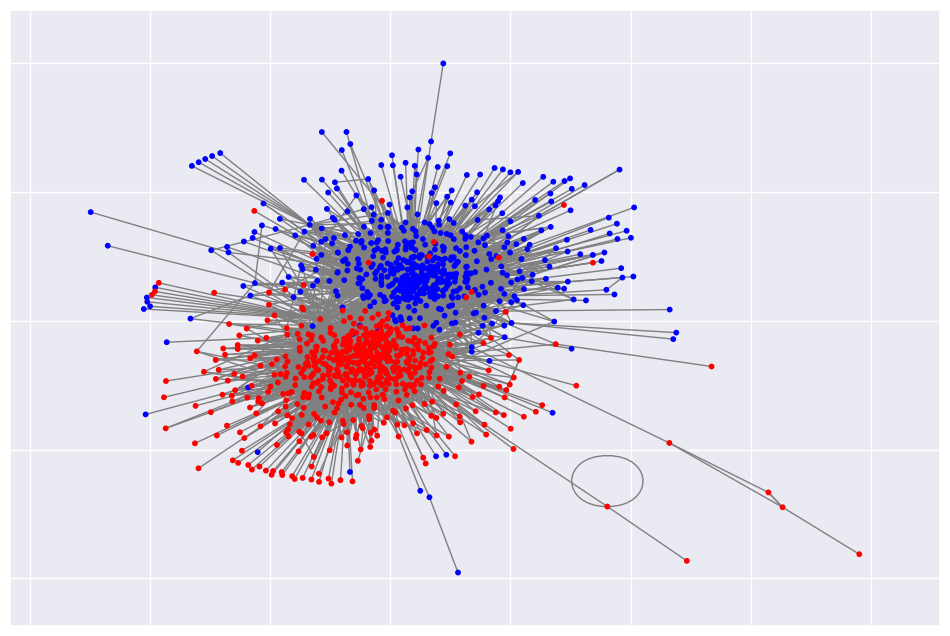

In [ ]:
G_polblogs = G_polblogs.to_undirected()

largest_cc = max(nx.connected_components(G_polblogs), key=len)
subgraph = G_polblogs.subgraph(largest_cc)

node_colors_subgraph = [color_map_polblogs[subgraph.nodes[node]['value']] for node in subgraph.nodes()]

plt.figure(figsize=(12, 8))
nx.draw_networkx(subgraph, node_size=10, with_labels=False, node_color=node_colors_subgraph, edge_color='gray')
plt.show()

Let us look at how many of those edges go to the same politically leaning blogs.

<ipython-input-23-c22c67135873>:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos=pos, edge_color=edge_colors)


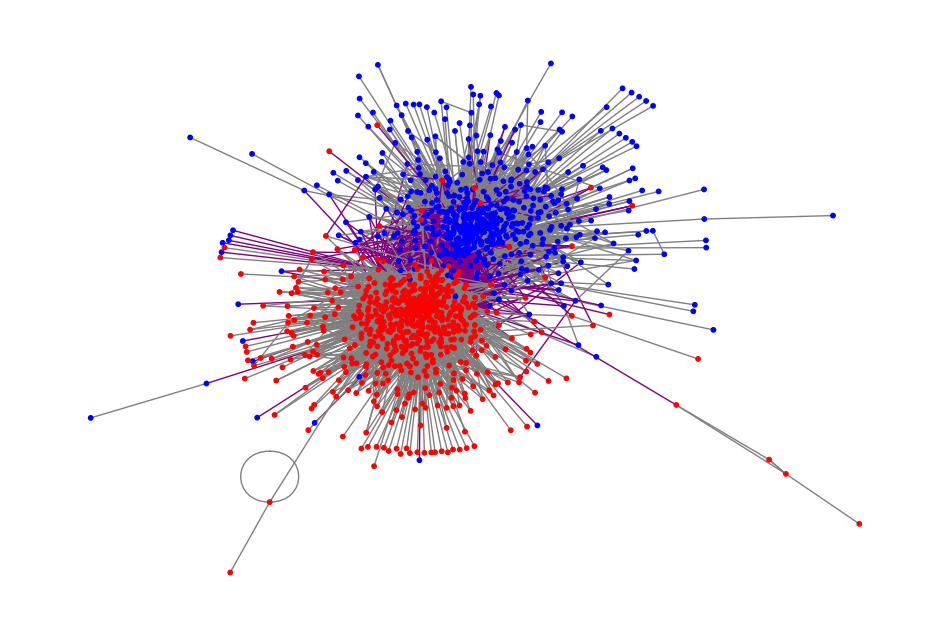

In [ ]:
node_colors_subgraph = [color_map_polblogs[subgraph.nodes[node]['value']] for node in subgraph.nodes()]

edge_colors = ['gray' if subgraph.nodes[edge[0]]['value'] == subgraph.nodes[edge[1]]['value'] else 'purple' for edge in subgraph.edges()]

plt.figure(figsize=(12, 8))

pos = nx.spring_layout(subgraph)

nx.draw_networkx_nodes(subgraph, pos=pos, node_size=10, node_color=node_colors_subgraph)

nx.draw_networkx_edges(subgraph, pos=pos, edge_color=edge_colors)

plt.axis('off')
plt.show()

The graph looks rather polarized, however we need computational ways to understand if that is the case. Let us use three different metrics of homophily that we can use to evaluate this.

## 2.1. E-I Index

Remember from the lecture that $$EI_\text{Index} =\frac{(ET - IT)}{(ET + IT)}$$

where, $ET$ represents the the number of intergroup (mixed) edges and $IT$ represents the the number of intragroup (non-mixed) edges.

The score ranges between +1 and −1:
 - values close to −1 indicate the network is dominated by intragroup
edges (homophily)
 - values close to +1 show the presence of heterophily



In [ ]:
ET = 0
IT = 0

for edge in subgraph.edges():
    node_a, node_b = edge
    if subgraph.nodes[node_a]['value'] != subgraph.nodes[node_b]['value']:
        ET += 1
    else:
        IT += 1

In [ ]:
EI_index = (ET - IT) / (ET + IT)
EI_index

-0.8231442191838232

Since the value we got is close to -1, we can see that the network is dominated by introgroup edges and thus is homophilic, which indicates high polarization.

## 2.2. Modularity

We will use the measure of modularity, which quantifies the difference between number of intra group edges in the network with the expected number of intra group edges.

The modularity $Q$ is defined as:
$$ Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j) $$

Where:

- $A_{ij}$ is the edge weight between nodes $i$ and $j$, or 1 if there is an edge and 0 otherwise.
- $k_i$ and $k_j$ are the sum of the weights of the edges attached to nodes $i$ and $j$, respectively.
- $m$ is the sum of all of the edge weights in the graph.
- $c_i$ and $c_j$ are the communities of nodes $i$ and $j$, respectively.
- $\delta$ is the Kronecker delta function, which is 1 if $c_i = c_j$ and 0 otherwise.

Modularity scores range from -1 to 1, where values close to 1 indicate strong community structure. We will luckily be using networkx to implement this, so its rather straightforward.

In [ ]:
from networkx.algorithms import community
import itertools

communities = {}
for node in subgraph.nodes(data=True):
    node_id, attr = node
    group = attr['value']
    if group not in communities:
        communities[group] = set()
    communities[group].add(node_id)

communities_list = list(communities.values())

In [ ]:
modularity_score = community.modularity(subgraph, communities_list)
modularity_score

0.411099306997572

From this we identify a somewhat moderately strong community structure.

## 2.3. Random Walk Controversy Score
Thisis a score based on of random walks on graphs. We know that there are authoritative nodes on both sides of the opinion (blogs that get a lot of links). Metric captures the intuition of how likely a random user on either side is to be exposed to authoritative content from the opposing side.

Garimella et al. define the Random Walk Controversy (RWC) measure as follows: *"Consider two random walks, one ending in partition X and one ending in partition Y , RWC is the difference of the probabilities of two events: (i) both random walks started from the partition they ended in and (ii) both random walks started in a partition other than the one they ended in."*.

RWC scores range from 0 to 1, where values close to 1 indicate a higher level of controversy or polarization within the network. For our implementation we will be using an already out-of-the-box solution.

In [ ]:
import random
from random_walk_controversy import get_rwc

left_nodes = [n for n, d in subgraph.nodes(data=True) if d['value'] == 0]
right_nodes = [n for n, d in subgraph.nodes(data=True) if d['value'] == 1]

node_percentage = 0.3
number_simulations = 1000

rwc_score = get_rwc(subgraph, left_nodes, right_nodes, node_percentage, number_simulations)
print(f"Random Walk Controversy Score: {rwc_score}")

Random Walk Controversy Score: 0.6051529686401874


We can see from here that the score is more towards 1 than 0, thus showing a slight leaning to polarization.

# 3. User type identification

In the paper [Political Discourse on Social Media:
Echo Chambers, Gatekeepers, and the Price of Bipartisanship](https://dl.acm.org/doi/pdf/10.1145/3178876.3186139) Garimella et al. introduce different types of users in social media echo chambers.

He calls gatekeepers users who consume content from both sides but only produce
content from one side. These users also have a higher page rank.

He calls partisans users that are significantly more polarized than bipartisan ones. These users have higher page rank, higher clustering co-efficient and
a higher fraction of their tweets receives a retweet.

---

We will do a modification of this logic on our poltical blogs dataset to show you how to categorize and identify different nodes. Let us define:

Gatekeepers - blogs that link to (consume) a broad spectrum of political content but predominantly link from (produce) content that aligns with a specific political ideology. They serve as informational bridges between divergent viewpoints, yet maintain a clear ideological stance in their content creation.

Partisans - Blogs that are deeply entrenched within their political group, both in terms of the content they link to (consume) and the content they produce, as indicated by the blogs that link to them (production). These blogs reinforce and amplify the ideology of their respective groups.

## 3.1. Calculating roles of blogs

In [ ]:
page_rank = nx.pagerank(subgraph)

simple_graph = nx.Graph(subgraph)
clustering_coefficient = nx.clustering(simple_graph)

page_rank_threshold = sorted(page_rank.values())[int(len(page_rank) * 0.9)]  #Top 10% PageRank
clustering_coefficient_threshold = sorted(clustering_coefficient.values())[int(len(clustering_coefficient) * 0.5)]  #Median

gatekeepers = []
partisans = []

for node in subgraph.nodes:
    if page_rank[node] > page_rank_threshold:
        if clustering_coefficient[node] > clustering_coefficient_threshold:
            partisans.append(node)
        else:
            gatekeepers.append(node)

len(gatekeepers), len(partisans)

(94, 28)

Let us now plot and see these users

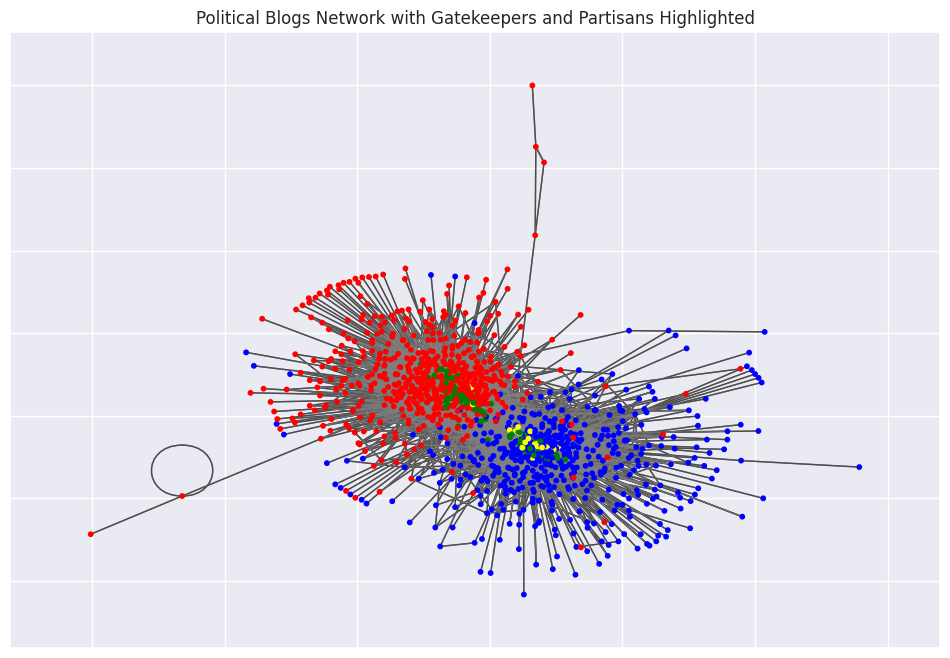

In [ ]:
node_colors = []
for node in subgraph.nodes():
    if node in gatekeepers:
        node_colors.append('green')
    elif node in partisans:
        node_colors.append('yellow')
    else:
        node_value = subgraph.nodes[node]['value']
        node_colors.append(color_map_polblogs[node_value])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, scale=2.0, iterations=50)

nx.draw_networkx(subgraph, pos, node_size=10, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5, edge_color='gray')
plt.title('Political Blogs Network with Gatekeepers and Partisans Highlighted')
plt.show()

In [ ]:
left_leaning_gatekeepers = sum(1 for node in gatekeepers if subgraph.nodes[node]['value'] == 0)
right_leaning_gatekeepers = sum(1 for node in gatekeepers if subgraph.nodes[node]['value'] == 1)

left_leaning_partisans = sum(1 for node in partisans if subgraph.nodes[node]['value'] == 0)
right_leaning_partisans = sum(1 for node in partisans if subgraph.nodes[node]['value'] == 1)

print(f"Left-leaning gatekeepers: {left_leaning_gatekeepers}")
print(f"Left-leaning partisans: {left_leaning_partisans}")
print(f"Right-leaning gatekeepers: {right_leaning_gatekeepers}")
print(f"Right-leaning partisans: {right_leaning_partisans}")

Left-leaning gatekeepers: 34
Left-leaning partisans: 26
Right-leaning gatekeepers: 60
Right-leaning partisans: 2


Lets also do a Chi-squared test to see how relevant these numbers really are. The calculation of the p-value specifically addresses the question of whether the distribution of political leanings among gatekeepers and partisans is independent of their group membership. Therefore:

$H_0$: There is no significant association between being a gatekeeper or a partisan and having a left-leaning or right-leaning political view. This implies that the distribution of political leanings is independent of whether a node is a gatekeeper or a partisan.

$H_A$: There is a significant association between being a gatekeeper or a partisan and having a left-leaning or right-leaning political view. This means that the distribution of political leanings is not independent of whether a node is a gatekeeper or a partisan; the two variables are related in some way.

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = [
    [left_leaning_gatekeepers, right_leaning_gatekeepers],
    [left_leaning_partisans, right_leaning_partisans]
]

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}")
print(f"p-value: {p_value}")
print(f"degrees of freedom: {dof}\n")
print(f"actual values: \n{contingency_table}")
print(f"expected values: \n{expected}")

Chi-squared: 25.515863687616438
p-value: 4.3876048099930066e-07
degrees of freedom: 1

actual values: 
[[34, 60], [26, 2]]
expected values: 
[[46.2295082 47.7704918]
 [13.7704918 14.2295082]]


Since our $\chi^2$ value is 25.515863687616438, it is significantly higher than the critical values for common levels of significance. This indicates a strong statistical significance beyond the conventional thresholds ($\alpha=0.05$ and $\alpha = 0.01$), suggesting a strong evidence against the null hypothesis, therefore showing association between the variables.

#Here you go, enjoy solving your homework!